# Project 2
This project will focus on comparing and contrasting the supervised and unsupervised algorithms we have learned so far. Clearly label each section and number in the notebook

In [176]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from plotnine import *

from sklearn.tree import DecisionTreeClassifier # Decision Tree

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.metrics import silhouette_score
from sklearn import metrics 

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.model_selection import LeaveOneOut 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict 

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelBinarizer

%matplotlib inline

# Part I
Use the dataset burgersOrPizza.csv to build 3 models that predict whether a food is a burger or pizza (you can use any of the predictive models we've learned).

For each model:
- Explore data (with ggplot)
- Explain which variables you're using to predict the outcome.
- Explain which model validation technique you're using and why.
- Explain why you did or did not choose to standardize your continuous variables.
- Evaluate how the model performed. Explain.

At the end:
- Compare the performance of the 3 models using the accuracy, and the confusion matrix (consider things like how many it got correct, which errors it was most likely to make...etc).

# I used the same variables, model validation, and standardization for all 3 models: 

I'm using all continuous variables to give my model maximum prediction power, except potassium and potassium 100g because pizza doesn't have any potassium. If you keep the potassium columns and try to drop NAs, then it keeps only burgers, so those columns have to be removed BEFORE we drop NAs. I chose not to use item name and description because there would be so many different factor levels for those that it would be essentially useless. The model could also use the titles to group burgers and pizzas together and that would defeat the point of predicting.

Because this is a small data set, I decided to use k fold cross validation with 5 folds. Its definitely small enough that it wouldn't warrant a test/train split, but big enough that I don't want to run 927 models with LOOCV.

I chose to standardize my variables because they're measured in different units and scales.

# Data Prep and Z Scoring

In [ ]:
bp = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/burgersOrPizza.csv")
bp.shape

bp = bp.drop("Item_Name",axis = 1)
bp = bp.drop("Item_Description",axis = 1) 
bp = bp.drop("Potassium",axis = 1) 
bp = bp.drop('Potassium_100g',axis=1) 

bp = bp.dropna() 

features = bp.columns[1:20]
X = bp[features]
y = bp["Food_Category"]

b = LabelBinarizer()
y = b.fit_transform(y)

z = StandardScaler()
z.fit(X)
X[features] = z.transform(X)

# 1. Logistic Regression

My model performed pretty well! My best k fold model that I used to train my final model had an accuracy score 89.6%. My confusion matrix shows 155 correct predictions and 18 incorrect predictions.

0.8959537572254336


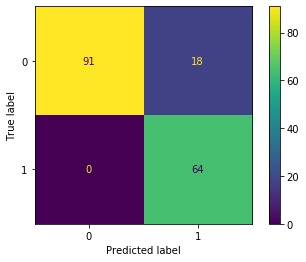

In [145]:
kf = KFold(n_splits = 5)
kf.split(X)
lr = LogisticRegression()
acc = []

for train_indices, test_indices in kf.split(X):
    X_train = X.iloc[train_indices]
    X_test  = X.iloc[test_indices]
    y_train = y[train_indices]
    y_test  = y[test_indices]
  
    model = lr.fit(X_train, y_train)
    acc.append(accuracy_score(y_test, model.predict(X_test)))
    
chosen_k = max(acc)
lr_final = lr.fit(X_train,y_train)
plot_confusion_matrix(lr_final, X_test, y_test)
print(lr_final.score(X_test,y_test))

# 2. K Nearest Neighbors

My model performed really well! My test accuracy using my best k fold model was 98.8%. The confusion matrix from my best model had only 4 incorrect predictions and around 167 correct predictions.

{1: 0.9754457303722239, 2: 0.9696694818058595, 3: 0.9653320821603586, 4: 0.9638828067980398, 5: 0.9566677093108122, 6: 0.9609946825148576, 7: 0.9465644875404025, 8: 0.949442185382129, 9: 0.9378688353664894, 10: 0.9320925868001251}


0.976878612716763

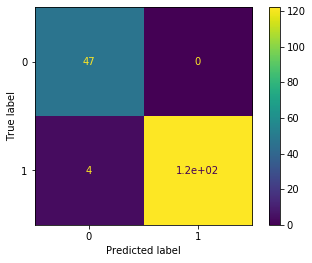

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

poss_k = [1,2,3,4,5,6,7,8,9,10]
acc = {}

for k in poss_k:
    kf = KFold(n_splits = 5)
    knn = KNeighborsClassifier(n_neighbors = k)
    acc[k] = np.mean(cross_val_score(knn, X_train, y_train, cv = kf))

print(acc)

chosen_k = max(acc, key=acc.get)

knn_final = KNeighborsClassifier(n_neighbors = chosen_k)
knn_final.fit(X_train,y_train)
plot_confusion_matrix(knn_final, X_test, y_test)

knn_final.score(X_test,y_test)

# 3. Decision tree 

This model did pretty well too! My average accuracy across my trees, or I guess technically my "forest" since I'm using the avg accuracy across all my k fold models, is 95.7% and I printed a confusion matrix at the end of each iteration of my for loop, and we can see that all of them have high amounts of correct predictions (in the top left box and bottom right box) and low amounts of incorrect predictions (bottom left box and top right box), which supports what we already saw in the accuracy scores.

[0.9826589595375722, 0.9942196531791907, 0.9075144508670521, 0.9479768786127167, 0.953757225433526]
0.9572254335260115
[14, 16, 10, 14, 14]


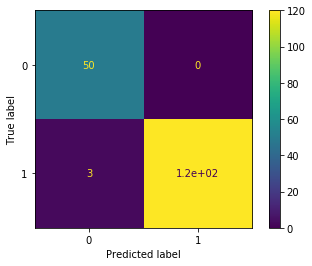

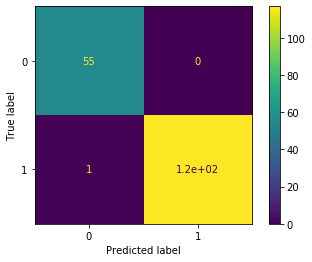

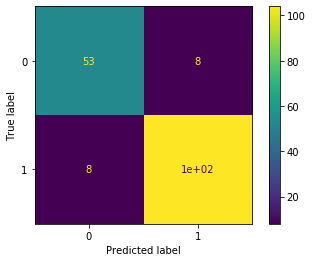

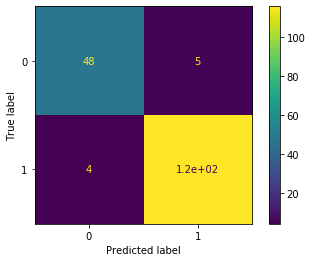

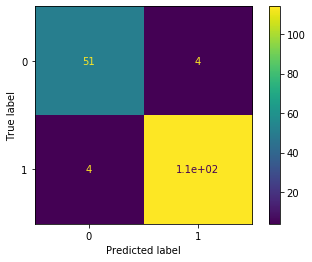

In [158]:
kf = KFold(5, shuffle = True)
acc = []
depth = []

for train, test in kf.split(X):
    X_train = X.iloc[train,]
    X_test = X.iloc[test,]
    y_train = y[train]
    y_test = y[test]
    
    tree = DecisionTreeClassifier()
    tree_mod = tree.fit(X_train,y_train)
    
    acc.append(tree.score(X_test,y_test))
    depth.append(tree.get_depth())
    plot_confusion_matrix(tree_mod, X_test, y_test)

print(acc)
print(np.mean(acc))
print(depth)

# Which model performed best?

Accuracies:

Decision tree: 95.7%

Logistic Regression: 89.6%

KNN: 98.8%

The KNN performed best, the decision tree was a close second, and the logistic regression came in third. All 3 models did pretty well overall. Although KNN did the best, it seems like the model is overfit. 98.8% accuracy really seems too good to be true, but it could just be that we have one or more really powerful variables that are different in burgers and pizza and make it easy to decide which is which. 

# Part II
Use the dataset KrispyKreme.csv to build 2 clustering models (you can use any of the clustering models we've learned).

For each model:
- Explore data (with ggplot)
- Explain which variables you're using to predict the outcome.
- Evaluate how the model performed using sihouette scores. Look at different numbers of cluseters (like k = 3,5..etc). Which number of clusters is the best fit?
- Describe the clusters (what are they like? how are they different)

At the end:
- Compare the clusters obtained by the two models. Overall are they similar? or really different (i.e. do they contain mostly the same members?)

Please get rid of extra analyses/superfluous code before turning it in. Turn in A PDF on Blackboard.

# Data Prep and Z Scoring

In [198]:
#1 oz = 28.3495 grams
#Converts all serving sizes to grams
kk = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/KrispyKreme.csv")
kk['Normalized_Serving_Size'] = np.where(kk['Serving_Size_Unit'] == 'oz', kk['Serving_Size'] * 28.3495, kk['Serving_Size'])

kk = kk.drop("Restaurant_Item_Name",axis = 1)
kk = kk.drop("restaurant",axis = 1)
kk = kk.drop("Item_Name",axis = 1)
kk = kk.drop("Item_Description",axis = 1)
kk = kk.drop("Serving_Size_text",axis = 1)
kk = kk.drop("Serving_Size",axis = 1)
kk = kk.drop("Serving_Size_Unit",axis = 1)
kk = kk.drop("Serving_Size_household",axis = 1)

# kk = kk.dropna() 

le = LabelEncoder()
kk["Food_Category"] = le.fit_transform(kk["Food_Category"])

features = kk.columns[0:24]
cont_features = kk.columns[2:24]

X = kk[features]
z = StandardScaler()
z.fit(X[cont_features])
X = z.transform(X[cont_features])

# 1. Model 1

I'm using ___ variables.

___ clusters is the best fit because it has the highest silhouette score, ____.

The clusters are

# 2. Model 2

I'm using ___ variables.

___ clusters is the best fit because it has the highest silhouette score, ____.

The clusters are

# Cluster comparison

The clusters were ____.